# Stereovision

<img src="img/main.png" width="50%">

### Definitions and General Overview


- **Epipolar Geometry**: describes the relationship between two camera views.

Let 2 cameras `C` and `C'` (optical center) looking at a `point X`. Each camera "see" x based on a set of physical constraints (camera' focal length...) not at their optical center, but a bit forward of them on a plane called the `focal/image plane`. These `x` and `x'` are what our camera set actually "see".

---

#### Epipole

- The epipole `e` is the projection of `C'` in `C` own focal plane. Symetrically we obtain `e'`.

---

#### Epipolar Line

- The projection of the line C - X onto `C'` focal plane. This results in a line passing through the epipole `e'` (since the projected line passes through C and e' being the image of C).  
- For a point x in the left image, its corresponding point x' in the right image must lie somewhere on the epipolar line l'—not just anywhere in the image. This is a huge constraint for matching points.

---

#### Epipolar plan

- The plan formed between the Real point `X` and our two cameras C and C'.
- Every possible position of X (for a given x and x') lies on this plane.

---

#### P, P' – The Camera Projection Matrices

Describe how the camera turns a 3D point (X) into a 2D pixel (x):

- $x = P \cdot X$   (left)  
- $x' = P' \cdot X$ (right)

This matrix encodes both the camera’s **internal** parameters (focal length, principal point, distortion, etc.) and its **external** parameters (position and orientation in space).

---

#### F – The Fundamental Matrix

How to go from x (2D) → x' (2D):

- F links the two camera images.
- It encodes their relative position and orientation.
- It satisfies the epipolar constraint:
- $x'^T \cdot F \cdot x = 0$ &nbsp; &nbsp; // The point x′ in the right image lies exactly on the epipolar line l′ that corresponds to point x in the left image.

---

#### E - The Essential Matrix

---

#### Other Definitions

- **Locus**: The set of all possible positions that a point can take.

## Imports

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import glob

from PIL import Image
from IPython.display import Image as IPImage

import cv2
import scipy
import random


#### Helper Functions

In [3]:
# ----- Helpers --------
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return np.uint8(gray)


def vector_product_cours(v):
        v = v.flatten()[:3]
        return np.array([
            [0,     -v[2],  v[1]],
            [v[2],   0,    -v[0]],
            [-v[1],  v[0],  0   ]
        ])


def get_unique_colors(n):
    import random
    random.seed(42)
    return [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(n)]


## Chessboard


We are given an image from each cameras taken from the same object. 

The goal here is to calibrate our cameras. We need to obtain the `P` and `F` matrixes :

1. Find equivalent points in both images (ex. chessboard corners).

2. Obtain cameras `intrinsic` (focal length, principal point) and `extrinsic` (rotation and translation) parameters (openCV).


3. Compute the Projection Matrix for each camera (How the real point X is transformed into x). P = K * (R|t)

4. Compute the Fundamental Matrix.


---





#### Opencv Documentation

In [4]:
### Documentation :


# cv2.findChessboardCorners(): This function is used to find the chessboard corners in an image.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a

# cv2.cornerSubPix(): This function will improve precision of corner's positions.    
    # https://docs.opencv.org/4.0.0/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e

# cv2.drawChessboardCorners(): This function will draw found corners for visual validation purpose. 
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022

# cv2.calibrateCamera(): This function will compute rotation vectors, and , based on corners found on multiple chessboards.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

#### Chosen Images

In [5]:
# We choose c4 as it has the most planar perspective
chosen_img_left = "c4Left.png"
chosen_img_right = "c4Right.png"

# OTHERS
    # chosen_img_left = "c2Left.png"
    # chosen_img_right = "c2Right.png"

    # chosen_img_left = "c3Left.png"       #! Doesn't detect...
    # chosen_img_right = "c3Right.png"

    # chosen_img_left = "c1Left.png"
    # chosen_img_right = "c1Right.png"

### 1. Image Pair Selection (`detect_chessboard_corners`)

In [6]:
def detect_chessboard_corners(image_path, pattern_size=(7, 7)):
    """
    Detect corners in an image and return results for display.
    """
    # Read
    img = cv2.imread(image_path)
        
    # Convert to grayscale
    grey = rgb2gray(img)
    
    # Find chessboard corners
    retval, corners = cv2.findChessboardCorners(img, pattern_size, None)
    
    # Prepare result dictionary
    result = {
        'success': retval,
        'image_rgb': cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
        'corners': None,
        'image_with_corners': cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    }
    
    if retval:
        # Improve corner precision
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        refined_corners = cv2.cornerSubPix(grey, corners, (11, 11), (-1, -1), criteria)
        
        # Draw corners on a copy of the image
        img_with_corners = img.copy()
        cv2.drawChessboardCorners(img_with_corners, pattern_size, refined_corners, retval)
        
        # Update result
        result['corners'] = refined_corners
        result['image_with_corners'] = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
    
    return result

#### Example

Corners detected successfully in both images!
Left image corners shape: (49, 1, 2)
Right image corners shape: (49, 1, 2)


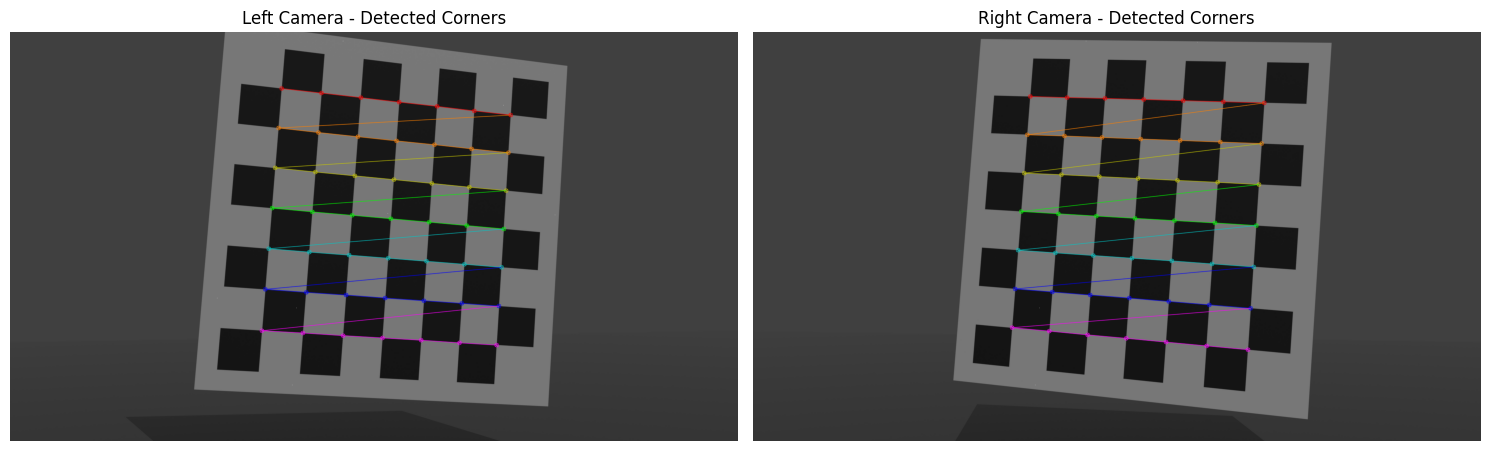

In [7]:
# EXAMPLE: set of one L/R images
chess_corners_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
chess_corners_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

# Display results
if chess_corners_left['success'] and chess_corners_right['success']:
    print("Corners detected successfully in both images!")
    print(f"Left image corners shape: {chess_corners_left['corners'].shape}")
    print(f"Right image corners shape: {chess_corners_right['corners'].shape}")
else:
    print(f"Corner detection - Left: {chess_corners_left['success']}, Right: {chess_corners_right['success']}")


# ====================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Display left image with corners
ax1.imshow(chess_corners_left['image_with_corners'])
ax1.set_title('Left Camera - Detected Corners')
ax1.axis('off')

# Display right image with corners
ax2.imshow(chess_corners_right['image_with_corners'])
ax2.set_title('Right Camera - Detected Corners')
ax2.axis('off')

plt.tight_layout()
plt.show()

### 2. Camera Calibration (get intrinsic and extrinsic parameters)

In [8]:
# METHOD :
    # 1. For each image in img_list, detect chessboard corners.
    # 2. Accumulate object points and image points.
    # 3. Input those points into cv2.calibrateCamera.
    # 4. Obtain both cameras intrinsic/extrinsic parameters.

    # Output : 
        # Intrinsic parameters (camera matrix, distortion coefficients) SAME for all Images.
        # Extrinsic parameters (rotation and translation vectors) DIFFER for each image.
    # Note: we extract the extrinsic params for our CHOSEN_images.

    # More images passed -> better results
    # Some images fail at corner detection -> those images are skipped.

    # INPUT:
        # objectPoints: Vector of vectors of calibration pattern points in the calibration pattern coordinate space.
        # imagePoints: 	Vector of vectors of the projections of calibration pattern points.
        # imageSize: Size of the image used only to initialize the intrinsic camera matrix.

    # OUTPUT:
        # retval: RMS reprojection error
        # cameraMatrix:  Refined camera intrinsic matrix
        # distCoeffs: Output vector of distortion coefficients.
        # rvecs: Output vector of rotati# More images passed -> better resultson vectors
        # tvecs 

def calibrate_camera(img_list, pattern_size):
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)            # Shape: (49, 3) for 7×7 corners
    objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)  # copy objp for each image
    object_points = []  # 3D points in real world space
    image_points = []   # 2D points in image plane
    successful_images = [] 

    for i in img_list:
        result = detect_chessboard_corners(i, pattern_size)
        if result["success"]:
            object_points.append(objp)
            image_points.append(result["corners"])
            successful_images.append(i)

    # Get image size from the first image
    first_img = cv2.imread(img_list[0])
    image_size = (first_img.shape[1], first_img.shape[0])  # (width, height)
        #print(f"Image size: {image_size}")

    # Calibrate camera
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        object_points, 
        image_points, 
        image_size, 
        None,  # Let OpenCV estimate initial camera matrix
        None   # Let OpenCV estimate initial distortion coefficients
    )

    return ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images


# Pass a list of images, receive a list of Projection Matrixes P.
# Choose the final P and P' based on the image with the orientation the most similar to final 3D image (here c4.png)

#### Example

In [9]:
# 1. Load images
img_list = glob.glob("./chessboards/*.png") # first is LEFT, then RIGHT (alphabetical order)
print("Found images:", len(img_list), "images: ", img_list)



# 2. Get Results
ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images = calibrate_camera(img_list, (7,7))
skipped_images = [img for img in img_list if img not in successful_images]
print(f"Successfully calibrated on {len(successful_images)} images.")
print(f"Skipped images: {skipped_images}")



# 3. We chose C4 images as basis, find their index in this list
left_idx = next(i for i, path in enumerate(successful_images) if chosen_img_left in path)
right_idx = next(i for i, path in enumerate(successful_images) if chosen_img_right in path)
print(f"\nChosen image (extrinsic p.) - Left: '{successful_images[left_idx]}', Right: '{successful_images[right_idx]}'")



# 4. Extract parameters for both
ret_left, mtx_left, dist_left = ret, camera_matrix, dist_coeffs
rvec_left, tvec_left = rvecs[left_idx], tvecs[left_idx]

ret_right, mtx_right, dist_right = ret, camera_matrix, dist_coeffs   # assume same camera with same intrinsics
rvec_right, tvec_right = rvecs[right_idx], tvecs[right_idx]



# 5. Display results
print(f"\nLeft: rvec={rvec_left.flatten()}, tvec={tvec_left.flatten()}")
print(f"Right: rvec={rvec_right.flatten()}, tvec={tvec_right.flatten()}")


Found images: 8 images:  ['./chessboards/c1Left.png', './chessboards/c1Right.png', './chessboards/c2Left.png', './chessboards/c2Right.png', './chessboards/c3Left.png', './chessboards/c3Right.png', './chessboards/c4Left.png', './chessboards/c4Right.png']
Successfully calibrated on 6 images.
Skipped images: ['./chessboards/c3Left.png', './chessboards/c3Right.png']

Chosen image (extrinsic p.) - Left: './chessboards/c4Left.png', Right: './chessboards/c4Right.png'

Left: rvec=[-0.06132213 -0.18139791  0.07797372], tvec=[-2.29981706 -3.66547699 19.81589077]
Right: rvec=[-0.04652955  0.2151451   0.06877919], tvec=[-2.25734709 -3.61952181 20.69358646]


### 3. Projection Matrixes

#### Calcul

In [10]:
# Projection Matrices P and P' :
    # usually : x = P * X 
    
    # But we must build P using the INTRINSIC and EXTRINSIC parameters:
    # P = K * [R | t]
        # where K is the camera intrinsic matrix, 
        # [R|t] is the extrinsic


# ======================================================

# 1. Build extrinsic matrices [R|t] (3x4)
R_left, _ = cv2.Rodrigues(rvec_left)   # Convert rotation vectors to rotation matrices
R_right, _ = cv2.Rodrigues(rvec_right) # 3x3 rotation matrix

RT_left = np.hstack([R_left, tvec_left.reshape(-1, 1)])
RT_right = np.hstack([R_right, tvec_right.reshape(-1, 1)]) 



# 3. Build projection matrices P = K * [R|t] //  P_ext = P_int * (R T) = K * (R|t)(3x4)
P_left = camera_matrix @ RT_left
P_right = camera_matrix @ RT_right  #camera_matrix from calibrate_camera()

print(f"Left Projection Matrix P: \n{P_left}")
print(f"\nRight Projection Matrix P': \n{P_right}")
# print(f"\nCheck dimensions ok (3x4): P_left={P_left.shape}, P_right={P_right.shape}")


# ================================
# Our convention : 
    # right camera to the right of the left camera (positive X direction).
    # C_left ---> C-right (positive X direction).


print("\n===== Check orientation convention: =====")

# 1. Camera's optical centers (T = -R @ C  <=> C = -R^T @ T)
C_left = -R_left.T @ tvec_left.reshape(-1,1)      # get World coordinates of left camera center
C_right = -R_right.T @ tvec_right.reshape(-1,1)  #
baseline = C_right - C_left                     # vector from left to right camera center, is it positive ?

print(f"Baseline vector: {baseline.flatten()}")
print(f"X component: {baseline[0, 0]:.4f}")

if baseline[0, 0] < 0:
    print("Reversed orientation.")




Left Projection Matrix P: 
[[ 2.22944860e+03 -2.16122223e+02  5.59152155e+02  1.41915121e+04]
 [ 2.70022583e+02  2.05272342e+03  6.42408937e+02  2.98882870e+03]
 [ 1.77726092e-01 -6.79331725e-02  9.81732408e-01  1.98158908e+01]]

Right Projection Matrix P': 
[[ 1.84010634e+03 -1.90794042e+02  1.38108917e+03  1.51231407e+04]
 [ 1.68294920e+01  2.07154499e+03  6.38508411e+02  3.55858569e+03]
 [-2.14836213e-01 -3.87521909e-02  9.75880971e-01  2.06935865e+01]]

===== Check orientation convention: =====
Baseline vector: [ 7.83702151 -0.58447323  0.15312859]
X component: 7.8370


#### Verification

In [11]:
# ====== Make reverse operations to check if everything is correct ======

# 1. Decompose P matrices to get back K, R, t and compare each with original camera_matrix, R, t

# 2. Check rotation matrix properties :
    # det=1 (preserves orientation and scale)
    # be orthogonal : R @ R.T = identity matrix

# 3. Check camera centers and baseline :
    # get the world coordinates of camera centers C = -R.T @ t
    # compute the distance between the 2 cameras center : baseline = ||C_left - C_right||

# 4. Reprojection error test :
    # Create 3D chessboard points in world coordinates from (0,0,0) to (6,6,0) 7x7 chessboard
    # Project those points using P and P' to get 2D image points
    # Compare those projected points with the detected corners from the images


# ================ CHECK ========================

# 1. Check if decomposition gives back original matrices
print("=== 1. MATRIX DECOMPOSITION CHECK ===")
K_left_check, R_left_check, t_left_check, _, _, _, _ = cv2.decomposeProjectionMatrix(P_left)
K_right_check, R_right_check, t_right_check, _, _, _, _ = cv2.decomposeProjectionMatrix(P_right)

# Normalize K matrices (they come back scaled)
K_left_check = K_left_check / K_left_check[2, 2]
K_right_check = K_right_check / K_right_check[2, 2]
camera_matrix_norm = camera_matrix / camera_matrix[2, 2]
# print(f"Original K:\n{camera_matrix_norm}")
# print(f"Decomposed K (left):\n{K_left_check}")
print(f"K_left matrices match: {np.allclose(camera_matrix_norm, K_left_check, atol=1e-3)}")
print(f"K_right matrices match: {np.allclose(camera_matrix_norm, K_right_check, atol=1e-3)}")

# 2. Check rotation matrix properties
print("\n=== 2. ROTATION MATRIX VALIDATION ===")
det_R_left = np.linalg.det(R_left)
det_R_right = np.linalg.det(R_right)
print(f"det(R_left) = {det_R_left:.6f} (should be ≈ 1.0)")
print(f"det(R_right) = {det_R_right:.6f} (should be ≈ 1.0)")

# Check orthogonality: R @ R.T should be identity
ortho_left = np.allclose(R_left @ R_left.T, np.eye(3), atol=1e-6)
ortho_right = np.allclose(R_right @ R_right.T, np.eye(3), atol=1e-6)
print(f"R_left is orthogonal: {ortho_left}")
print(f"R_right is orthogonal: {ortho_right}")

# 3. Check camera centers and baseline
print("\n=== 3. CAMERA GEOMETRY ===")
C_left = -R_left.T @ tvec_left.reshape(-1, 1)
C_right = -R_right.T @ tvec_right.reshape(-1, 1)
baseline = np.linalg.norm(C_left - C_right)

print(f"Left camera center: {C_left.flatten()}")
print(f"Right camera center: {C_right.flatten()}")
print(f"Baseline distance: {baseline:.4f}")
print(f"Baseline OK (>0.01): {baseline > 0.01}")

# 4. CRITICAL: Reprojection error test
print("\n=== 4. REPROJECTION ERROR TEST ===")

# Create 3D chessboard points [ (0,0,0), (1,0,0), ..., (6,6,0) ]
objp = np.zeros((7 * 7, 3), np.float32)
objp[:,:2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)
objp_homogeneous = np.hstack([objp, np.ones((objp.shape[0], 1))]).T  # 4x49

# Project using P matrices
projected_left = P_left @ objp_homogeneous
projected_left = (projected_left[:2, :] / projected_left[2, :]).T  # Convert to 2D

projected_right = P_right @ objp_homogeneous
projected_right = (projected_right[:2, :] / projected_right[2, :]).T


# Get detected corners for comparison
if chess_corners_left['success'] and chess_corners_right['success']:
    detected_corners_left = chess_corners_left['corners'].reshape(-1, 2)
    detected_corners_right = chess_corners_right['corners'].reshape(-1, 2)
    
    # Calculate reprojection errors
    error_left = np.linalg.norm(projected_left - detected_corners_left, axis=1)
    error_right = np.linalg.norm(projected_right - detected_corners_right, axis=1)
    
    print(f"Left camera  - Mean error: {np.mean(error_left):.3f} px, Max: {np.max(error_left):.3f} px")
    print(f"Right camera - Mean error: {np.mean(error_right):.3f} px, Max: {np.max(error_right):.3f} px")
    
else:
    print("ERROR: No corner detection results available for comparison")



=== 1. MATRIX DECOMPOSITION CHECK ===
K_left matrices match: True
K_right matrices match: True

=== 2. ROTATION MATRIX VALIDATION ===
det(R_left) = 1.000000 (should be ≈ 1.0)
det(R_right) = 1.000000 (should be ≈ 1.0)
R_left is orthogonal: True
R_right is orthogonal: True

=== 3. CAMERA GEOMETRY ===
Left camera center: [ -0.96256025   4.82835804 -19.67625074]
Right camera center: [  6.87446126   4.24388481 -19.52312216]
Baseline distance: 7.8603
Baseline OK (>0.01): True

=== 4. REPROJECTION ERROR TEST ===
Left camera  - Mean error: 0.041 px, Max: 0.075 px
Right camera - Mean error: 0.042 px, Max: 0.068 px


#### 3D - Reconstruction (P matrixes)

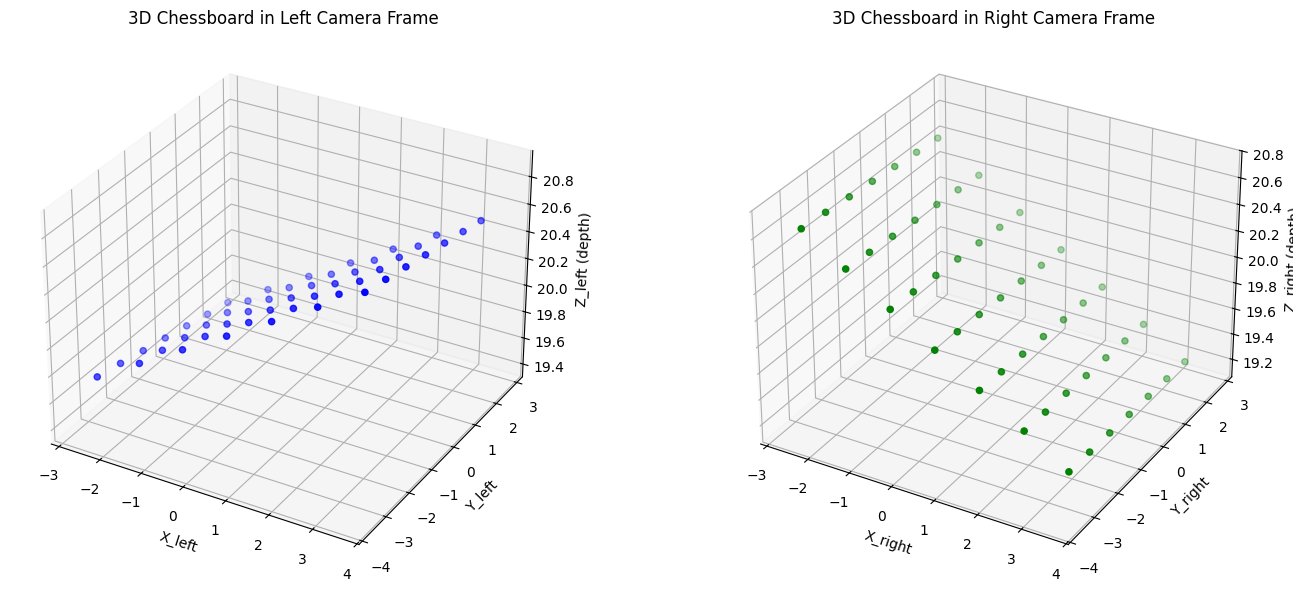

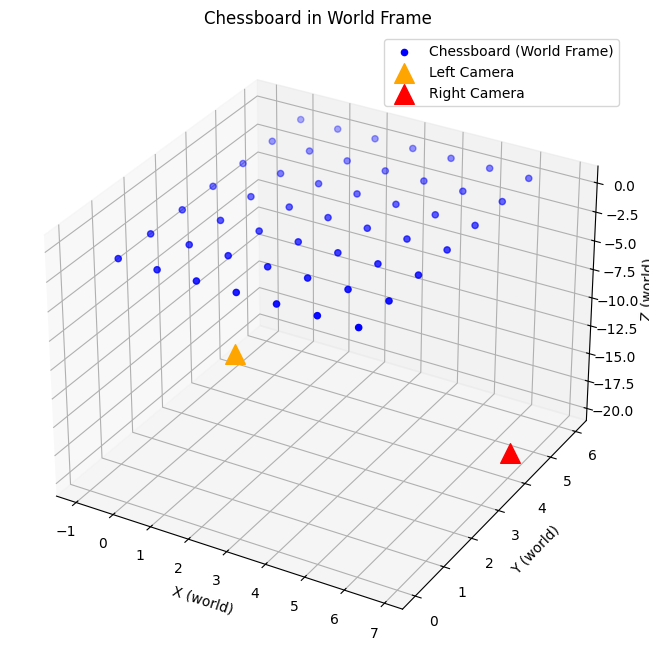

In [12]:
# Goal : project 2D points back to 3D using triangulation
    # 1. get chessboard corners in both images (done)
    # 2. use cv2.triangulatePoints() with P and P'
    # 3. Draw those triangulated points in World Frame
    # 4. Convert points into camera frame, and then draw them

# Triangulation logic :
    # Input : 
        # Proj matrix (contains C, R, t) in both images
        # chessboard 2D points in both images
    # For each point, find the closest intersection of the 2 rays :
        # One from camera center C through x.
        # One from camera center C' through x'.
    # This intersection is our REAL 3D point X. 
    # (due to distortion/noise, rays may not intersect exactly, so openCV finds the closest point)

# ================================================================================

chess_corners_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
chess_corners_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

if chess_corners_left['success'] and chess_corners_right['success']:
    corners_left = chess_corners_left['corners']
    corners_right = chess_corners_right['corners']

    # Triangulate (OpenCV expects 2xN arrays)
    X_hom = cv2.triangulatePoints(P_left, P_right, corners_left.reshape(-1,2).T, corners_right.reshape(-1,2).T)
    X = (X_hom[:3] / X_hom[3]).T  # Nx3

    # Express to Camera Frame (triangulatePoints is in board 2D frame)
    X_left_cam = (R_left @ X.T + tvec_left.reshape(3, 1)).T
    X_right_cam = (R_right @ X.T + tvec_right.reshape(3, 1)).T

    # ============================================================

    # 3D scatter: left and right camera frames side by side
    # World->camera: x_cam = R * X_world + t
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(15, 6))
    ax1.scatter(X_left_cam[:, 0], X_left_cam[:, 1], X_left_cam[:, 2], c='b', marker='o')
    ax1.set_title('3D Chessboard in Left Camera Frame')
    ax1.set_xlabel('X_left')
    ax1.set_ylabel('Y_left')
    ax1.set_zlabel('Z_left (depth)')

    ax2.scatter(X_right_cam[:, 0], X_right_cam[:, 1], X_right_cam[:, 2], c='g', marker='o')
    ax2.set_title('3D Chessboard in Right Camera Frame')
    ax2.set_xlabel('X_right')
    ax2.set_ylabel('Y_right')
    ax2.set_zlabel('Z_right (depth)')

    plt.tight_layout()
    plt.show()


    # ====== World coordinates ======
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')  

    # Plot chessboard in world frame
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', marker='o', label='Chessboard (World Frame)')

    # Optional: Add camera positions
    ax.scatter(C_left[0], C_left[1], C_left[2], c='orange', marker='^', s=200, label='Left Camera')
    ax.scatter(C_right[0], C_right[1], C_right[2], c='red', marker='^', s=200, label='Right Camera')

    ax.set_xlabel('X (world)')
    ax.set_ylabel('Y (world)')
    ax.set_zlabel('Z (world)')
    ax.legend()
    plt.title('Chessboard in World Frame')
    plt.show()

### 4. Fundamental Matrix

#### Manually

In [13]:
# Theoretical computation of F :
    # F = [e']× · P' · P+ 
        #
        # P+ is the pseudo-inverse of P


# Method :
    # 1. Find C, C' from R, t
    # 2. Find e' = P' * C
    # 3. Find [e']x (gives epipolar line direction)
    # 4. Find P+  (gives the inverse projection as close as possible)
    # 5. Compute F (3x3 mtrix relating the 2 images)


def F_mat_manual(P_left, P_right, R_left, R_right, tvec_left, tvec_right):
    """ Equation: F = [e']× · P' · P⁺ 
    
    Consider prime is right, non-prime is left.

    1. Find C, C
    2. Find e'
    3. Find [e']x
    4. Find P⁺
    5. Compute F
    
    """
    # 1. Camera's optical centers (T = -R @ C  <=> C = -R^T @ T)
    C_left = -R_left.T @ tvec_left.reshape(-1, 1)      # reshape: turns [x, y, z] into [[x], [y], [z]]
    C_left_homogeneous = np.vstack((C_left, 1))       # Convert C_left to homogeneous coordinates (add rows of 1's)
    C_right = -R_right.T @ tvec_right.reshape(-1, 1)

    # 2. e': epipole
    e_prime = P_right @ C_left_homogeneous

    # 3. [e']×
    e_prime_cross = vector_product_cours(e_prime)

    # P⁺: Pseudo-inverse of P  : https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html
    P_left_pinv = np.linalg.pinv(P_left)  # 4x3 (inverse of 3x4)

    # Fundamental matrix computation
    F_manual = e_prime_cross @ P_right @ P_left_pinv 

    return F_manual

# =============================
F_manual = F_mat_manual(P_left, P_right, R_left, R_right, tvec_left, tvec_right)
print(f"=== Fundamental Matrix F (Manual): ===\n{F_manual}")

=== Fundamental Matrix F (Manual): ===
[[-1.14827206e-03 -1.51159789e+00  9.81912118e+02]
 [-1.58287273e+00 -2.48054213e-04  1.76842584e+04]
 [ 1.01616066e+03 -1.47438562e+04 -1.90043723e+06]]


#### With OpenCV

In [14]:
# Method :
    # 1. get chessboard corners
    # 2. use cv2.findFundamentalMat() with those points

    # openCV uses the epipolar constraint and solves it for F : 
    # x' * F * x = 0  (we give x and x')
    # Since F and -F are both solutions, we choose the one matching our convention.
    # then we normalize this F.

    # mask is used to tell which points are inliers (fit the model) e.g. how much points are actually used.

    # Consider prime is right, non-prime is left.


# =========================
def F_mat_opencv(pts_left, pts_right, method=cv2.FM_8POINT):
    """ Compute fundamental matrix using OpenCV
        Equation: pts_right^T @ F @ pts_left = 0

        #https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a
    """
    F_opencv, mask = cv2.findFundamentalMat(pts_left, pts_right, method)
    return F_opencv , mask


def get_chess_F_mat_opencv():
    # Extract corresponding points from c4 images for OpenCV method
    chess_corners_left= detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
    chess_corners_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

    if chess_corners_left['success'] and chess_corners_right['success']:
        # Get corresponding corner points
        pts_left = chess_corners_left['corners'].reshape(-1, 2)
        pts_right = chess_corners_right['corners'].reshape(-1, 2)

        print(f"pts_left dtype: {pts_left.dtype}, shape: {pts_left.shape}")
        print(f"pts_right dtype: {pts_right.dtype}, shape: {pts_right.shape}")


        F_opencv, mask = F_mat_opencv(pts_left, pts_right)
        
        # F_opencv = F_opencv.T

        # Sign correction: F and -F both satisfy epipolar constraint (scale ambiguity)
        # Align sign convention with F_manual by checking F[2,2] element
        if np.sign(F_opencv[2, 2]) != np.sign(F_manual[2, 2]):
            F_opencv = -F_opencv
        
        # Normalize for numerical stability
        F_opencv = F_opencv / np.linalg.norm(F_opencv)



        print("========= Fundamental Matrix F (OpenCV): ==========")
        print(F_opencv)

        # Check Epipolar constraint for all inlier points
        print(f"Inliers (epipolar constraint checks): {np.sum(mask)} / {len(mask)} passed.")
    return F_opencv, mask


F_opencv, _ = get_chess_F_mat_opencv()



pts_left dtype: float32, shape: (49, 2)
pts_right dtype: float32, shape: (49, 2)
========= Fundamental Matrix F (OpenCV): ==========
[[-5.35494821e-07 -8.63153741e-07  3.87675362e-03]
 [ 7.21961356e-08 -1.23534960e-09  4.05098486e-03]
 [-2.32724431e-03 -3.29229082e-03 -9.99976152e-01]]
Inliers (epipolar constraint checks): 49 / 49 passed.


#### Comparison

In [15]:
# Compare our manual F and OpenCV F :

    # 1. find the epilines L' = F @ x for all given x.

    # 2. check if epilines are nearly horizontal

    # 3. check if F satisfies epipolar constraint.

    # 4. find the epipole location in right image (Projects the left camera center 
        # (in homogeneous coordinates) into the right image using Pright)

    # 5. Get the relative orientation between the 2 cameras (R_relative = R_right * R_left^T)
        # are cameras almost parallel ?

    # 6. compute distance between 2 cameras and check if this line is (almost) horizontal.

    # 7. do all the above in one fnct.


# =======================================

def get_epilines(F, points, verbose=True):
    """ Find Epipolar L' = F @ x (x homogenous !!) """
    # Convert to homogeneous coordinates (add column of 1's)
    X_HOM = np.hstack([points, np.ones((points.shape[0], 1))])  # (N, 3)
    
    # Compute epilines: F @ x for each point
    if verbose: epilines = (F @ X_HOM.T).T  # Transpose X_hom from (N, 3) to (3, N)- each row is [a, b, c]
    
    print(f"Computed {epilines.shape[0]} epipolar lines.")
    return epilines

def compute_epiline_angles(F, points):
    """
    Compute angles of epilines from horizontal.
    
    Returns:
        numpy array of angles in degrees [-90, 90]
    """
    epilines = get_epilines(F, points)
    angles = []
    
    for line in epilines:
        a, b, c = line
        angle_rad = np.arctan2(a, -b)
        angle_deg = np.degrees(angle_rad)
        
        # Normalize to [-90, 90] range
        if angle_deg > 90:
            angle_deg -= 180
        elif angle_deg < -90:
            angle_deg += 180
        
        angles.append(angle_deg)
    
    return np.array(angles)



def check_epipolar_constraint(F, pts_left, pts_right):
    """
    Compute epipolar constraint errors: x_right^T · F · x_left = 0
    
    Args:
        F: 3x3 fundamental matrix
        pts_left: Nx2 array of points in left image
        pts_right: Nx2 array of corresponding points in right image
    
    Returns:
        numpy array of absolute errors for each point pair
    """
    pts_left_hom = np.hstack([pts_left, np.ones((len(pts_left), 1))])
    pts_right_hom = np.hstack([pts_right, np.ones((len(pts_right), 1))])
    
    errors = []
    for i in range(len(pts_left_hom)):
        error = pts_right_hom[i:i+1] @ F @ pts_left_hom[i:i+1].T
        errors.append(abs(error[0, 0]))
    
    return np.array(errors)

def compute_epipole_location(F, C_left, P_right, img_shape):
    """
    Find epipole location in right image.
    
    Args:
        F: 3x3 fundamental matrix
        C_left: 3x1 left camera center
        P_right: 3x4 right projection matrix
        img_shape: tuple (height, width) of right image
    
    Returns:
        dict with keys: 'position' (x, y), 'inside_image' (bool)
    """
    C_left_hom = np.vstack([C_left, [[1]]])
    epipole_hom = P_right @ C_left_hom
    epipole_2d = (epipole_hom[:2] / epipole_hom[2]).flatten()
    
    img_h, img_w = img_shape
    inside = (0 <= epipole_2d[0] <= img_w) and (0 <= epipole_2d[1] <= img_h)
    
    return {
        'position': epipole_2d,
        'inside_image': inside
    }


def compute_relative_rotation(R_left, R_right):
    R_relative = R_right @ R_left.T
    
    # Extract Euler angles
    from scipy.spatial.transform import Rotation as Rot
    r = Rot.from_matrix(R_relative)
    euler_deg = r.as_euler('xyz', degrees=True)
    
    # Check if approximately identity (parallel cameras)
    is_parallel = np.allclose(R_relative, np.eye(3), atol=0.1)
    
    return {
        'matrix': R_relative,
        'euler_angles': euler_deg,
        'is_parallel': is_parallel
    }

def compute_baseline_info(C_left, C_right):
    """
    Compute baseline distance and direction between cameras.
    
    Args:
        C_left: 3x1 left camera center
        C_right: 3x1 right camera center
    
    Returns:
        dict with keys: 'vector', 'distance', 'primarily_horizontal'
    """
    baseline_vector = (C_right - C_left).flatten()
    baseline_distance = np.linalg.norm(baseline_vector)
    
    # Check if baseline is primarily horizontal (X direction)
    primarily_horizontal = (abs(baseline_vector[0]) > abs(baseline_vector[1]) and 
                           abs(baseline_vector[0]) > abs(baseline_vector[2]))
    
    return {
        'vector': baseline_vector,
        'distance': baseline_distance,
        'primarily_horizontal': primarily_horizontal
    }


# Result
def verify_fundamental_matrix(  F, pts_left, pts_right, 
                                R_left, R_right, C_left, C_right, 
                                P_right, img_shape, verbose=True    ):
    results = {}
    
    # 1. Epipolar constraint errors - respect epipolar constraint ?
    errors = check_epipolar_constraint(F, pts_left, pts_right)
    results['epipolar_errors'] = {
        'mean': np.mean(errors),
        'max': np.max(errors),
        'all_pass': np.all(errors < 0.01)
    }
    
    # 2. Epiline angles
    sample_points = pts_left[::5]  # Sample every 5th point
    angles = compute_epiline_angles(F, sample_points)
    results['epiline_angles'] = {
        'mean': np.mean(angles),
        'std': np.std(angles),
        'min': np.min(angles),
        'max': np.max(angles),
        'nearly_horizontal': abs(np.mean(angles)) < 5.0
    }
    
    # 3. Epipole location
    epipole_info = compute_epipole_location(F, C_left, P_right, img_shape)
    results['epipole'] = epipole_info
    
    # 4. Matrix determinant (should be ≈ 0)
    det = np.linalg.det(F)
    results['determinant'] = {
        'value': det,
        'nearly_zero': abs(det) < 1e-6
    }
    
    # 5. Relative rotation
    rotation_info = compute_relative_rotation(R_left, R_right)
    results['relative_rotation'] = rotation_info
    
    # 6. Baseline
    baseline_info = compute_baseline_info(C_left, C_right)
    results['baseline'] = baseline_info
    
    # 7. Overall assessment
    all_checks_pass = (
        results['epipolar_errors']['all_pass'] and
        results['determinant']['nearly_zero'] and
        results['baseline']['distance'] > 0.01
    )
    results['overall_pass'] = all_checks_pass
    
    # Print results if verbose
    if verbose:
        print("="*70)
        
        print("\n1. EPIPOLAR CONSTRAINT (x_right^T · F · x_left = 0)")
        print(f"   Mean error: {results['epipolar_errors']['mean']:.6f}")
        print(f"   Max error:  {results['epipolar_errors']['max']:.6f}")
        print(f"   All < 0.01: {results['epipolar_errors']['all_pass']}")
        print(f"   Status: {'OK' if results['epipolar_errors']['all_pass'] else 'Error'}")
        
        print("\n2. EPILINE ANGLES")
        print(f"   Mean: {results['epiline_angles']['mean']:.2f}°")
        print(f"   Std:  {results['epiline_angles']['std']:.2f}°")
        print(f"   Range: [{results['epiline_angles']['min']:.2f}°, {results['epiline_angles']['max']:.2f}°]")
        print(f"   Nearly horizontal: {results['epiline_angles']['nearly_horizontal']}")
        print(f"   Status: {'OK' if results['epiline_angles']['nearly_horizontal'] else 'Error'}")
        
        print("\n3. EPIPOLE LOCATION")
        pos = results['epipole']['position']
        print(f"   Position: ({pos[0]:.1f}, {pos[1]:.1f})")
        print(f"   Inside image: {results['epipole']['inside_image']}")
        if results['epipole']['inside_image']:
            print(f"   Note: Epipole inside image → cameras are verged (epilines converge)")
        
        print("\n4. MATRIX DETERMINANT")
        print(f"   det(F) = {results['determinant']['value']:.2e}")
        print(f"   Nearly zero: {results['determinant']['nearly_zero']}")
        print(f"   Status: {'OK' if results['determinant']['nearly_zero'] else 'Error'}")
        
        print("\n5. RELATIVE ROTATION")
        euler = results['relative_rotation']['euler_angles']
        print(f"   Euler angles (XYZ): [{euler[0]:.2f}°, {euler[1]:.2f}°, {euler[2]:.2f}°]")
        print(f"   Cameras parallel: {results['relative_rotation']['is_parallel']}")
        
        print("\n6. BASELINE")
        vec = results['baseline']['vector']
        print(f"   Vector: [{vec[0]:.3f}, {vec[1]:.3f}, {vec[2]:.3f}]")
        print(f"   Distance: {results['baseline']['distance']:.4f}")
        print(f"   Primarily horizontal: {results['baseline']['primarily_horizontal']}")
        print(f"   Status: {'OK' if results['baseline']['distance'] > 0.01 else 'Error'}")
        
        print("\n" + "="*70)
        print(f"OVERALL: {'OK' if all_checks_pass else 'Error'}")
        print("="*70 + "\n")
    
    return results







In [16]:
# ==================================================
# Get test points from chessboard
chess_corners_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
chess_corners_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")
pts_left = chess_corners_left['corners'].reshape(-1, 2)
pts_right = chess_corners_right['corners'].reshape(-1, 2)

F_opencv_norm = F_opencv / np.linalg.norm(F_opencv)
F_manual_norm = F_manual / np.linalg.norm(F_manual)

img_resolution = (1080, 1920)

# ====== F_opencv ========
print("Testing F_opencv_norm:")
results_opencv = verify_fundamental_matrix(
    F_opencv_norm, pts_left, pts_right,
    R_left, R_right, C_left, C_right,
    P_right, img_resolution,
    verbose=True
)
# ====== F_manual ========
print("\n\nTesting F_manual_norm:")
results_manual = verify_fundamental_matrix(
    F_manual_norm, pts_left, pts_right,
    R_left, R_right, C_left, C_right,
    P_right, img_resolution,
    verbose=True
)

# Compare
if results_opencv['overall_pass'] and results_manual['overall_pass']:
    print("OK: Both F matrices are valid!")


Testing F_opencv_norm:
Computed 10 epipolar lines.

1. EPIPOLAR CONSTRAINT (x_right^T · F · x_left = 0)
   Mean error: 0.000136
   Max error:  0.000485
   All < 0.01: True
   Status: OK

2. EPILINE ANGLES
   Mean: -35.42°
   Std:  2.00°
   Range: [-39.34°, -32.35°]
   Nearly horizontal: False
   Status: Error

3. EPIPOLE LOCATION
   Position: (-9753.9, 649.0)
   Inside image: False

4. MATRIX DETERMINANT
   det(F) = 5.76e-27
   Nearly zero: True
   Status: OK

5. RELATIVE ROTATION
   Euler angles (XYZ): [-0.24°, 22.70°, -1.21°]
   Cameras parallel: False

6. BASELINE
   Vector: [7.837, -0.584, 0.153]
   Distance: 7.8603
   Primarily horizontal: True
   Status: OK

OVERALL: OK



Testing F_manual_norm:
Computed 10 epipolar lines.

1. EPIPOLAR CONSTRAINT (x_right^T · F · x_left = 0)
   Mean error: 0.000269
   Max error:  0.000773
   All < 0.01: True
   Status: OK

2. EPILINE ANGLES
   Mean: -0.94°
   Std:  1.14°
   Range: [-2.61°, 0.86°]
   Nearly horizontal: True
   Status: OK

3. EPIPO

## Suzanne


In [17]:
# We are provided 2 folders of the laser-scan of the same object (monkey head) 
# from 2 different cameras.

# Method:
    # 1. get the set of points of the laser line in each image 
        # (e.g. same as detecting chessboard corners for the chessboard.)

    # 2. Match the points between the 2 images

    # 3. Triangulate







### Choose F matrix

In [18]:
FUNDAMENTAL_MATRIX = F_manual #F_manual_2 #  # F_manual
# FUNDAMENTAL_MATRIX = F_opencv #F_manual_2 #  # 

### OpenCV mask and treshold

#### Mask: 1 Image

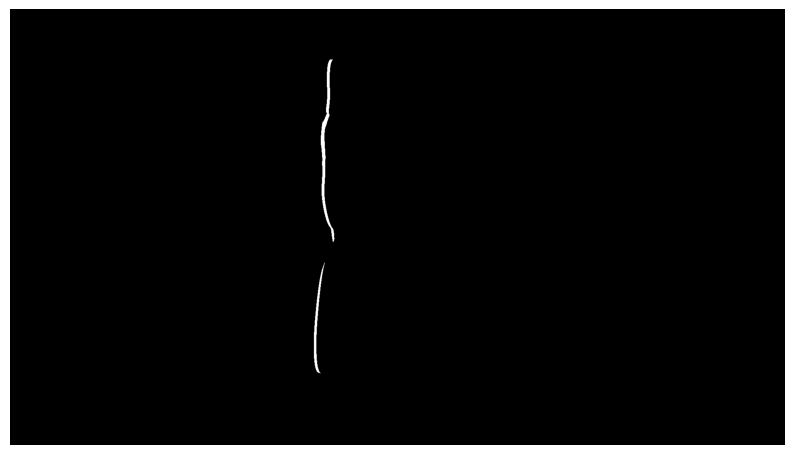

In [19]:
# Goal: apply different masks and thresholds to extract the laser line.

# ==========================
path = './scanRight/scan0014.png'
types = ["THRESH_BINARY", "THRESH_BINARY_INV", "THRESH_TRUNC","THRESH_TOZERO", "THRESH_TOZERO_INV"]
final_type = types[0]
threshold_value = 127


def thresh_image(path, value, type):
    img = cv2.imread(path)

    # Extract RED channel only (index 2 in BGR)
    red_channel = img[:, :, 2]

    ret, mask = cv2.threshold(red_channel,value,255,getattr(cv2, type))
    # mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    return mask_rgb



# ==================================================================
binary = thresh_image(path, threshold_value, types[0])
binary_inv = thresh_image(path, threshold_value, types[1])
trunc = thresh_image(path, threshold_value, types[2])
to_zero = thresh_image(path, threshold_value, types[3])
to_zero_inv = thresh_image(path, threshold_value, types[4])


titles = ['BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [binary, binary_inv, trunc, to_zero, to_zero_inv]


# fig, axes = plt.subplots(2, 3, figsize=(16, 12))  # Bigger figure, 2x3 grid

# for i in range(5):
#     row = i // 3
#     col = i % 3
#     axes[row, col].imshow(images[i])
#     axes[row, col].set_title(titles[i], fontsize=14)
#     axes[row, col].axis('off')

# # Hide the 6th (empty) slot
# axes[1, 2].axis('off')

# plt.tight_layout()
# plt.show()

# 
plt.figure(figsize=(10, 10))
plt.imshow(binary)
plt.title(f'')
plt.axis('off')
plt.show()


#### Mask: all Images

GIF saved to laser_scan_animation.gif


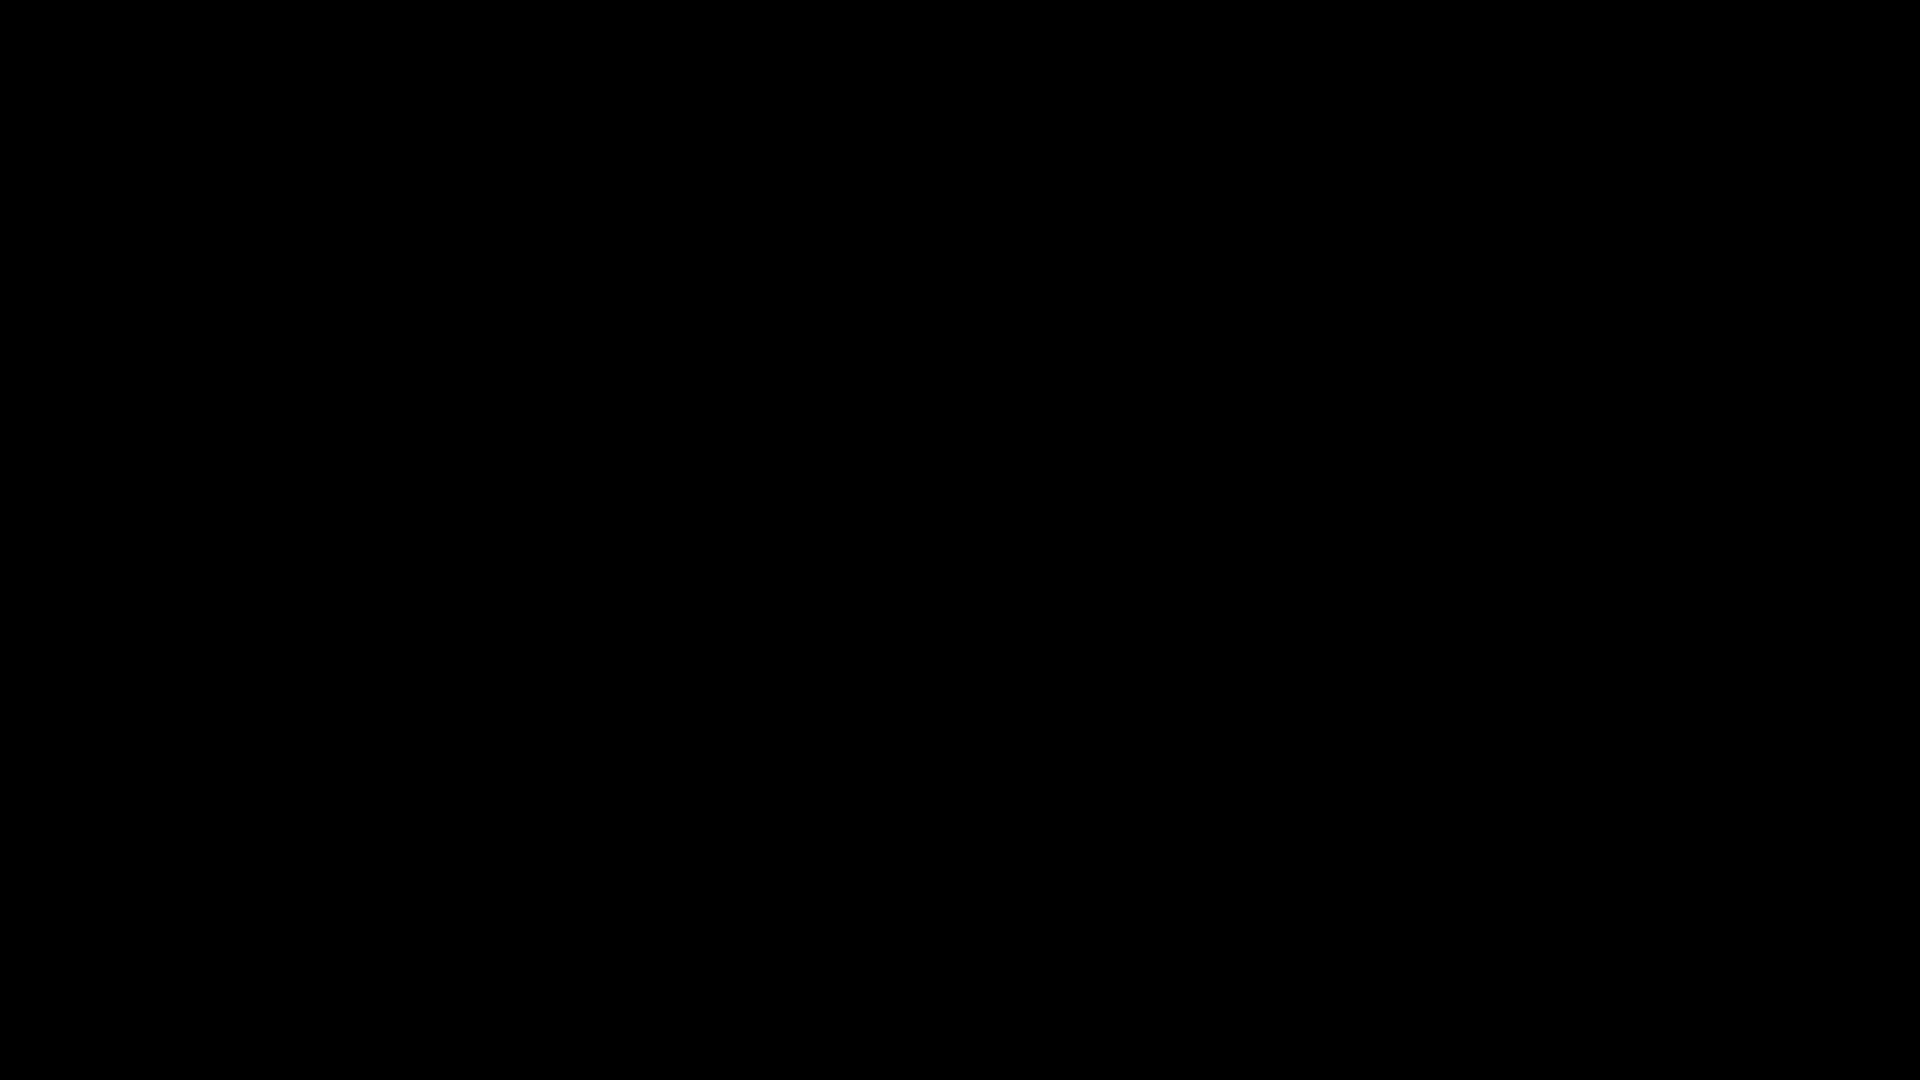

In [20]:
frames = []
image_files = glob.glob("scanRight/*.png")

for i, file in enumerate(image_files):
    processed_img = thresh_image(file, threshold_value, types[0])

    # Convert to PIL Image
    pil_img = Image.fromarray(processed_img)
    frames.append(pil_img)

# Save as GIF
if frames:
    output_path = "laser_scan_animation.gif"
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=100,  # milliseconds per frame
        loop=0  # infinite loop
    )
    print(f"GIF saved to {output_path}")
# Display the GIF in Jupyter
display(IPImage(output_path))

### Epipolar Lines

In [21]:
# Goal :
#         Extract laser points, get epilines and draw them on the image.
#         For x in left-image, find x' in right-image which must lie on L'.
#         Find epilines following this equation : L' = F * x

def extract_laser_pixels(binary_mask, verbose=True):
    """Extract laser pixel coordinates from binary mask."""
    laser_points = np.argwhere(binary_mask > 0)  # Returns (row, col), finds pixels with value > 0
    laser_points = laser_points[:, [1, 0]]  # Swap  (y, x) to (x, y)
    if verbose: print(f"Extracted {laser_points.shape[0]} laser points.")
    return laser_points

def get_epilines(F, points, verbose=True):
    """ Find Epipolar L' = F @ x (x homogenous !!) """
    # Convert to homogeneous coordinates (add column of 1's)
    X_HOM = np.hstack([points, np.ones((points.shape[0], 1))])  # (N, 3)
    
    # Compute epilines: F @ x for each point
    epilines = (F @ X_HOM.T).T  # Transpose X_hom from (N, 3) to (3, N)- each row is [a, b, c]
    
    if verbose: print(f"Computed {epilines.shape[0]} epipolar lines.")
    return epilines

def draw_epilines(img, points, color=(0, 255, 0), thickness=1):
    """draw ax + by + c = 0 """
    img_with_lines = img.copy()
    height, width = img_with_lines.shape[:2]

    for line in points:
        a, b, c = line
        
        # Calculate two points on the line at image boundaries
        # At x=0: y = -c/b
        # At x=width: y = -(a*width + c)/b
        
        if abs(b) > 1e-6:  # Avoid division by zero
            y0 = int(-c / b)
            y1 = int(-(a * width + c) / b)
            x0, x1 = 0, width
        else:  # Nearly vertical line
            x0 = x1 = int(-c / a)
            y0, y1 = 0, height
        
        # Draw line
        cv2.line(img_with_lines, (x0, y0), (x1, y1), color, thickness)
    
    return img_with_lines



#### Chessboard : Epilines

=== Testing epilines on calibration images ===
Computed 49 epipolar lines.


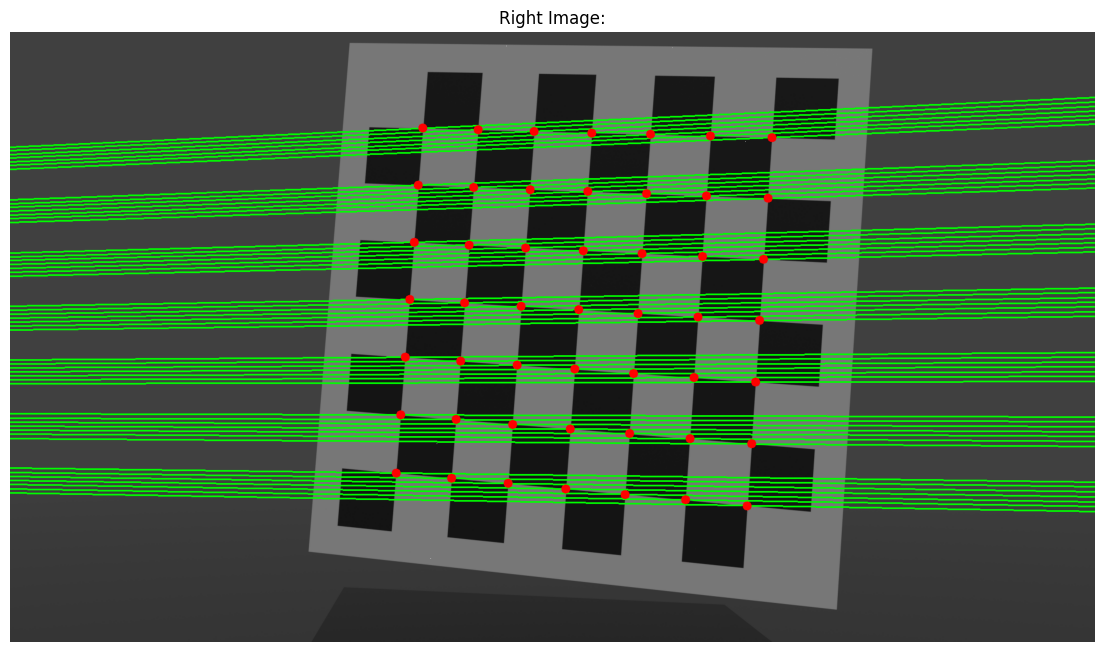

In [22]:
# ========== Draw epilines on a single image ===========

print("=== Testing epilines on calibration images ===")

# Get corresponding corners from BOTH images
result_test_left = detect_chessboard_corners("./chessboards/c4Left.png")
result_test_right = detect_chessboard_corners("./chessboards/c4Right.png")

pts_left_test = result_test_left['corners'].reshape(-1, 2)
pts_right_test = result_test_right['corners'].reshape(-1, 2)

# Compute epilines in RIGHT image from LEFT points
epilines_right = get_epilines(FUNDAMENTAL_MATRIX, pts_left_test)

# draw epilines
img_test_right = cv2.imread("./chessboards/c4Right.png")
img_test_right_rgb = cv2.cvtColor(img_test_right, cv2.COLOR_BGR2RGB)
img_visual = draw_epilines(img_test_right_rgb, epilines_right, color=(0, 255, 0), thickness=2)

# Draw points in RED
for i in range(len(pts_right_test)):
    x, y = pts_right_test[i]
    cv2.circle(img_visual, (int(x), int(y)), 8, (255, 0, 0), -1)

plt.figure(figsize=(14, 10))
plt.imshow(img_visual)
plt.title('Right Image:')
plt.axis('off')
plt.show()



### Suzanne : Epilines

Extracted 23406 laser points.
Length sampled points: 235
Computed 235 epipolar lines.


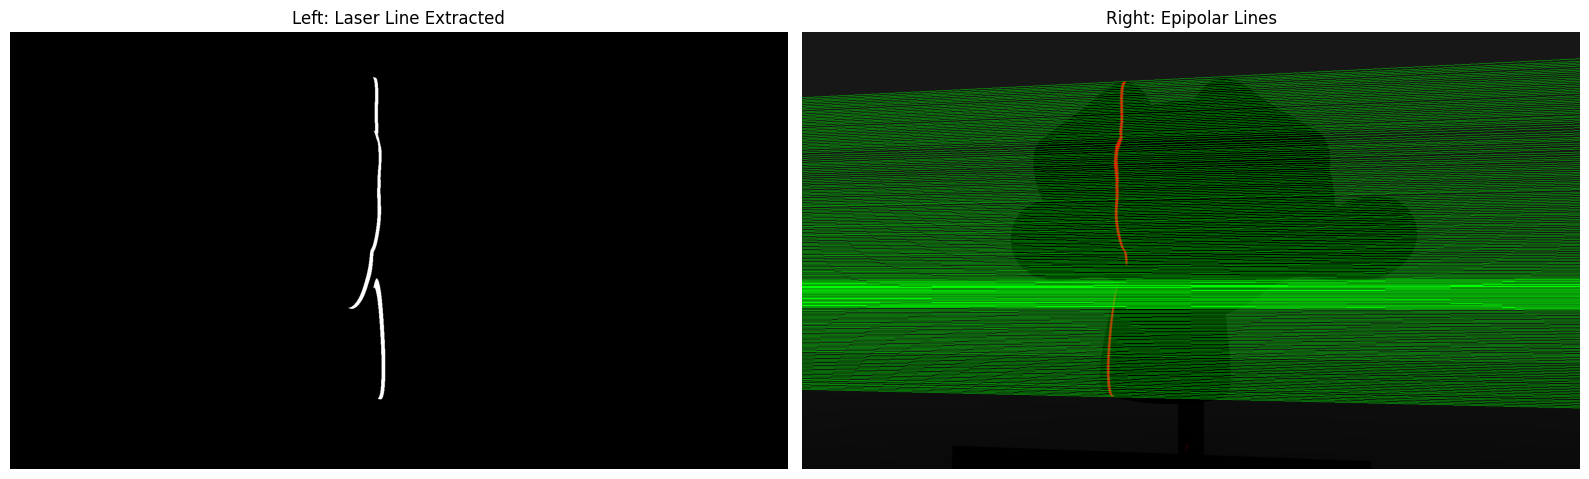

In [23]:
# ========== Draw epilines on a single image ===========

# Left image processing
path_left = './scanLeft/0014.png'
path_right = './scanRight/scan0014.png'

# Get img, filter only the laser and extract points coordinates from laser line
masked_img = thresh_image(path_left, threshold_value, final_type)
laser_points_left = extract_laser_pixels(masked_img)
sampled_points = laser_points_left[::100]  # Sample every 100th point
print(f'Length sampled points: {len(sampled_points)}')

# Compute epilines in RIGHT image using LEFT points
epilines_right = get_epilines(FUNDAMENTAL_MATRIX, sampled_points)

# Load and draw epilines on RIGHT image
img_right = cv2.imread(path_right)
img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
img_with_epilines = draw_epilines(img_right_rgb, epilines_right, color=(0, 255, 0), thickness=1)

# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(masked_img)
ax1.set_title('Left: Laser Line Extracted')
ax1.axis('off')

ax2.imshow(img_with_epilines)
ax2.set_title('Right: Epipolar Lines')
ax2.axis('off')

plt.tight_layout()
plt.show()

#### Epiplines Gif : Suzanne

GIF saved as laser_epilines_right.gif


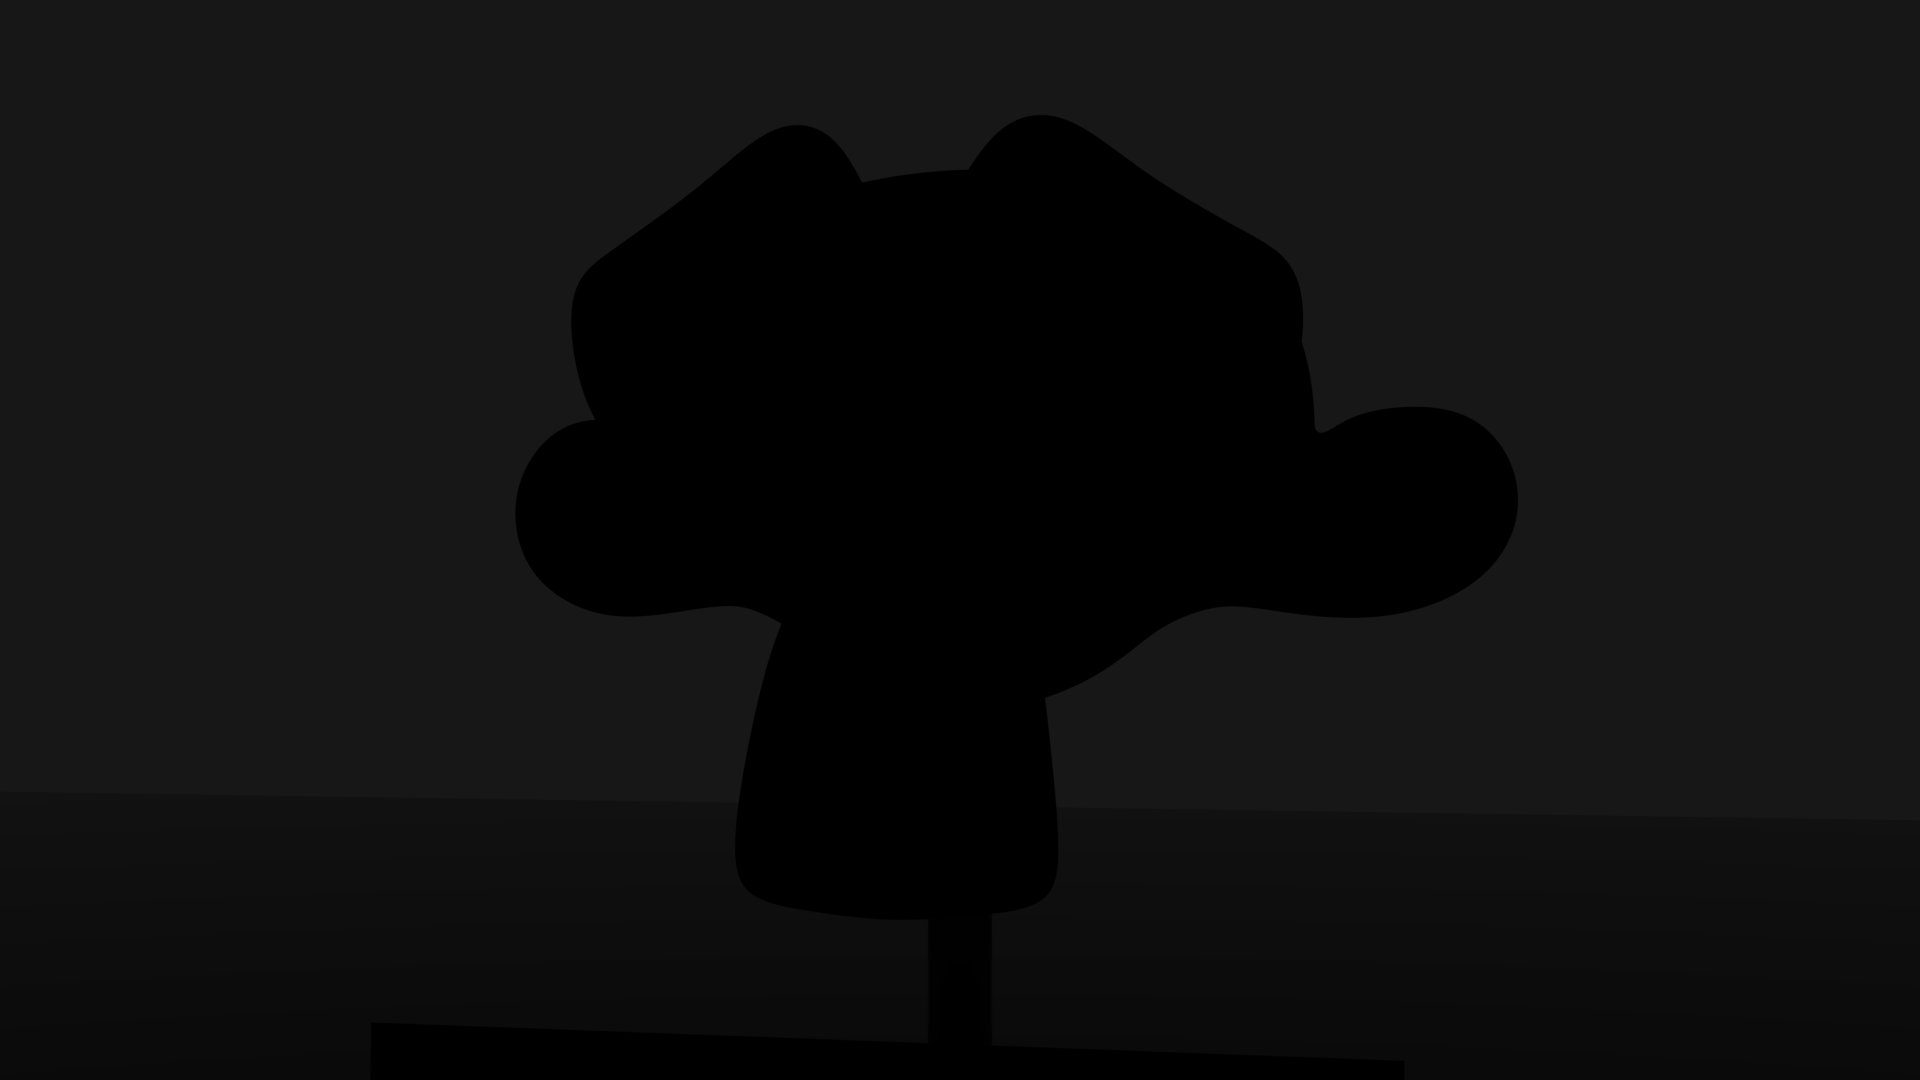

In [24]:
def gif_all_epilines(left_folder, right_folder, sample_rate=100):
    left_images = sorted(glob.glob(f"{left_folder}/*.png"))
    right_images = sorted(glob.glob(f"{right_folder}/*.png"))
    frames = []

    for left_path, right_path in zip(left_images, right_images):
        # Get laser points
        masked_img = thresh_image(left_path, threshold_value, final_type)
        laser_points_left = extract_laser_pixels(masked_img, verbose=False) 
        sampled_points = laser_points_left[::sample_rate]
        
        # Epilines in right image
        epilines_right = get_epilines(FUNDAMENTAL_MATRIX, sampled_points, verbose=False)
        img_right = cv2.imread(right_path)
        img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
        img_with_epilines = draw_epilines(img_right_rgb, epilines_right, color=(0, 255, 0), thickness=1)
        
        # Convert to PIL Image for GIF (right only)
        frames.append(Image.fromarray(img_with_epilines))

    return frames

# Generate frames
frames = gif_all_epilines('./scanLeft', './scanRight', sample_rate=100)

# Save GIF
if frames:
    output_path = "laser_epilines_right.gif"
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )
    print(f"GIF saved as {output_path}")
    
    # Display the GIF
    display(IPImage(output_path))


### Matching Pairs : Suzanne

In [25]:
# Method:
    # 1. get laser pixels in left image
    # 2. Compute epilinies in right image : L' = F * x
    # 3. For each epiline L', find the closest corresponding pixel on the right laser scan
    # 4. Matches those points as pairs (x, x')



def find_matching_pairs(left_image, right_image, sample_rate=100):
    
    # 1. Get laser points
    masked_img_left = thresh_image(left_image, threshold_value, final_type)
    laser_points_left = extract_laser_pixels(masked_img_left, verbose=False)
    sampled_points = laser_points_left[::sample_rate]  
    
    # 2. Epilines in right image
    epilines_right = get_epilines(FUNDAMENTAL_MATRIX, sampled_points, verbose=False)
    
    # 3. for each epiline, find matching laser pixel
    masked_img_right = thresh_image(right_image, threshold_value, final_type)
    laser_points_right = extract_laser_pixels(masked_img_right, verbose=False)
    

    # 4. For each epiline, find closest laser point
    pairs = []
    left_pairs = []
    right_pairs = []
    for lft_pt, epiline in zip(sampled_points, epilines_right):
        a, b, c = epiline
        
        # Find closest laser point on right image
        min_dist = float('inf')
        best_match = None
        
        for rgt_pt in laser_points_right:
            x0, y0 = rgt_pt
            dist = abs(a * x0 + b * y0 + c) / np.sqrt(a**2 + b**2)
            if dist < min_dist:
                min_dist = dist
                best_match = rgt_pt
        
        if best_match is not None:
            pairs.append((lft_pt, best_match))
            left_pairs.append(lft_pt)
            right_pairs.append(best_match)

    return pairs, left_pairs, right_pairs



Found 235 matching pairs of laser points.


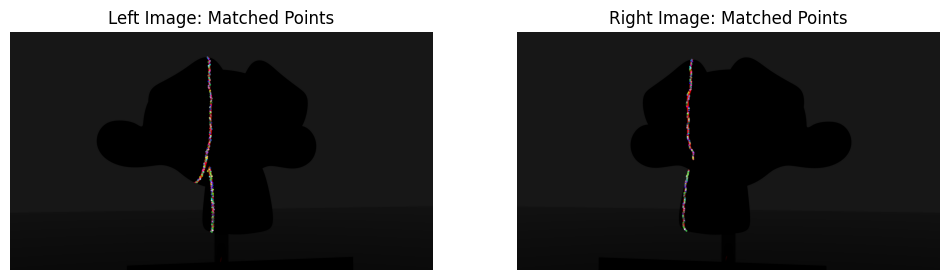

In [26]:
# Draw the matched pairs of points in the same color in both images 
# and se if they match.

pairs, _, _ = find_matching_pairs(path_left, path_right, 100)
print(f"Found {len(pairs)} matching pairs of laser points.")

# =====================================
img_left = cv2.imread(path_left)
img_right = cv2.imread(path_right)
img_left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

colors = get_unique_colors(len(pairs))
# Draw points in images to see if match ok
for idx, (l, r) in enumerate(pairs):
    # Left
    cv2.circle(img_left_rgb, center=tuple(l), radius=4, color=colors[idx], thickness=-1)
    # Right
    cv2.circle(img_right_rgb, center=tuple(r), radius=4, color=colors[idx], thickness=-1)


# ========
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Left Image: Matched Points")
plt.imshow(img_left_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Right Image: Matched Points")
plt.imshow(img_right_rgb)
plt.axis('off')
plt.show()






### 3D Triangulation:

Lengths left_pairs: 235, right_pairs: 235
success


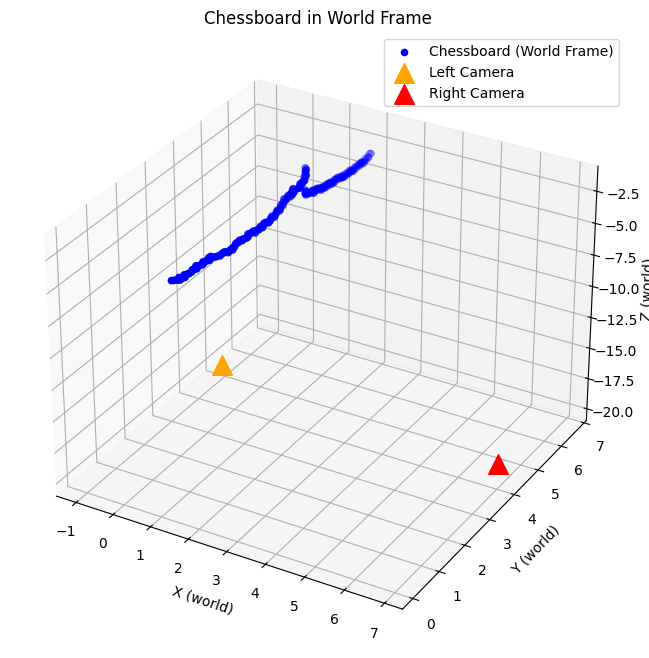

In [40]:

# Goal : project 2D points back to 3D using triangulation
    # 1. get laser points in both images (done)
    # 2. use cv2.triangulatePoints() with P and P'
    # 3. Draw those triangulated points in World Frame


_, left_pairs, right_pairs = find_matching_pairs(path_left, path_right, 100)

# convert to array
left_pairs = np.array(left_pairs, dtype=np.float32)
right_pairs = np.array(right_pairs, dtype=np.float32)
print(f'Lengths left_pairs: {len(left_pairs)}, right_pairs: {len(right_pairs)}')


# Triangulate - (World frame)
X_hom = cv2.triangulatePoints(P_left, P_right, left_pairs.T, right_pairs.T)
X = (X_hom[:3] / X_hom[3]).T  # Nx3

# Express to Camera Frame 
# X_left_cam = (R_left @ X.T + tvec_left.reshape(3, 1)).T
# X_right_cam = (R_right @ X.T + tvec_right.reshape(3, 1)).T

print("success")

# ========== Plot ====================
plot = True
if plot:
    # ====== Camera Frame ======
    # World->camera: x_cam = R * X_world + t
    # fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(15, 6))
    # ax1.scatter(X_left_cam[:, 0], X_left_cam[:, 1], X_left_cam[:, 2], c='b', marker='o')
    # ax1.set_title('3D Chessboard in Left Camera Frame')
    # ax1.set_xlabel('X_left')
    # ax1.set_ylabel('Y_left')
    # ax1.set_zlabel('Z_left (depth)')

    # ax2.scatter(X_right_cam[:, 0], X_right_cam[:, 1], X_right_cam[:, 2], c='g', marker='o')
    # ax2.set_title('3D Chessboard in Right Camera Frame')
    # ax2.set_xlabel('X_right')
    # ax2.set_ylabel('Y_right')
    # ax2.set_zlabel('Z_right (depth)')

    # plt.tight_layout()
    # plt.show()


    # ====== World coordinates ======
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')  

    # Plot chessboard in world frame
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', marker='o', label='Chessboard (World Frame)')

    # Optional: Add camera positions
    ax.scatter(C_left[0], C_left[1], C_left[2], c='orange', marker='^', s=200, label='Left Camera')
    ax.scatter(C_right[0], C_right[1], C_right[2], c='red', marker='^', s=200, label='Right Camera')

    ax.set_xlabel('X (world)')
    ax.set_ylabel('Y (world)')
    ax.set_zlabel('Z (world)')
    ax.legend()
    plt.title('Chessboard in World Frame')

    # ax.view_init(elev=-30, azim=60)

    plt.show()




### Full 3D Reconstruction :

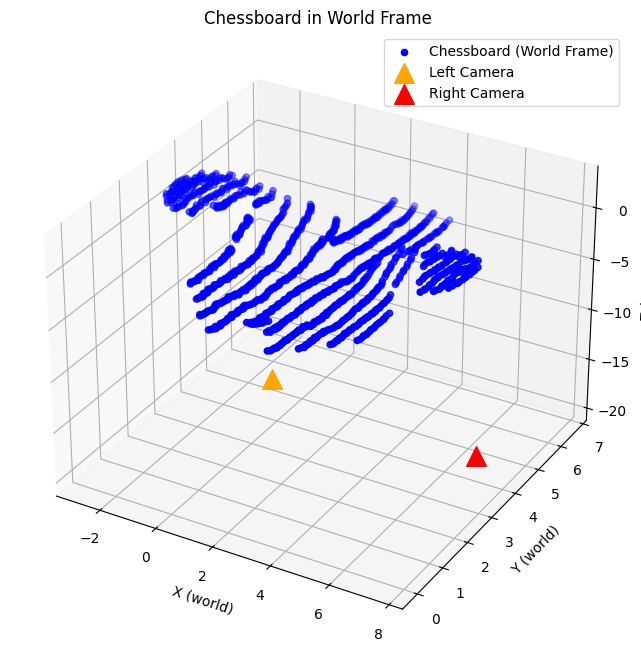

In [ ]:




def reconstruct(left_folder, right_folder, sample_rate=100):
    left_images = sorted(glob.glob(f"{left_folder}/*.png"))
    right_images = sorted(glob.glob(f"{right_folder}/*.png"))
    X_all = []

    for left_path, right_path in zip(left_images, right_images):
        
        # Get matching pairs
        _, left_pairs, right_pairs = find_matching_pairs(left_path, right_path, 100)

        # convert to array
        left_pairs = np.array(left_pairs, dtype=np.float32)
        right_pairs = np.array(right_pairs, dtype=np.float32)

        if left_pairs.size == 0 or right_pairs.size == 0:continue # Skip if no pairs found

        # Triangulate - (World frame)
        X_hom = cv2.triangulatePoints(P_left, P_right, left_pairs.T, right_pairs.T)
        X = (X_hom[:3] / X_hom[3]).T  # Nx3
        X_all.append(X)

    return X_all




# Save points here 
X = reconstruct('./scanLeft', './scanRight', sample_rate=100)
X_concat = np.vstack(X)


In [ ]:
# ====== World coordinates ======
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')  

# Plot chessboard in world frame
ax.scatter(X_concat[:, 0], X_concat[:, 1], X_concat[:, 2], c='blue', marker='o', label='Chessboard (World Frame)')
# Optional: Add camera positions
ax.scatter(C_left[0], C_left[1], C_left[2], c='orange', marker='^', s=200, label='Left Camera')
ax.scatter(C_right[0], C_right[1], C_right[2], c='red', marker='^', s=200, label='Right Camera')

ax.set_xlabel('X (world)')
ax.set_ylabel('Y (world)')
ax.set_zlabel('Z (world)')
ax.legend()
plt.title('Chessboard in World Frame')

ax.view_init(elev=-30, azim=60)

plt.show()

---

### Objectives Grid :

- Projection matrices of the cameras are computed (3 points)
- Fundamental matrix is computed (2 points)

.

- Red lines are sampled for the pairing process (1 point)
- Epipolar lines are computed (2 points)

.

- Matching pairs are found (3 points)
- 3D points are triangulated (3 points)

.

- The final 3D points cloud is displayed (1 point)
- The student can explain what's going on (5 points)

---

## Setup & Debug


### Linux (Fedora):
1. Download pip and virtual_env :
> sudo dnf install python3.14-pip python3.14-virtualenv

2. Create the new venv :
> python -m venv stereoVision_venv

3. Activate the venv and install dependencies :
```
>>> source stereoVision_venv/bin/activate
>>> pip install -r requirements.txt
```

4. Register our venv as a Jupyter kernel:
```
>>> python -m ipykernel install --user --name=stereoVision_venv --display-name="Python (stereoVision_venv)"
>>> jupyter kernelspec list
```